<a href="https://colab.research.google.com/github/SEOYUNJE/Lung_Diseases_Detection/blob/main/Chest_X_Ray_%7C_Lung_Diseases%5BEffNet%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/seoyunje/rapid-cxr-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/rapid-cxr-dataset


100%|██████████| 3.68G/3.68G [00:42<00:00, 93.2MB/s]


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256
    
- `Label Unique`: Label Unique>=2 & No Finding 삭제
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8)

- `Label Smoothing`: 0.15
    
- `Loss`: CategorialCrossEntropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip, Rotate(limit=2.5)
    
- `Strong Augment`: X
  
- `BackBone Model`: TF EfficientNetB0 Noisy Student
    
- `Freezing Layer`: 10% Layers
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [2]:
import os
import gc
import random
import ctypes
from tqdm import tqdm
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image
import albumentations as albu

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')


## tensorflow version
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow.keras.backend as K

print('tensorflow version: ', tf.__version__)
os.environ['CUDA_IS_VISIBLE'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None

tensorflow version:  2.17.0
Using 0 GPUs


In [3]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [5]:
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else:
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

**CXR 10 Dataset**

=> There are 3,000 Datasets(each label has 300 datasets)

In [6]:
USE_CXR = True

In [8]:
if USE_CXR:
    df = pd.read_csv('/content/rapid-cxr-dataset/metadata.csv')
    tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', '*','*','*', '*'))}

    df['path'] = df['Image Index'].map(tmp)

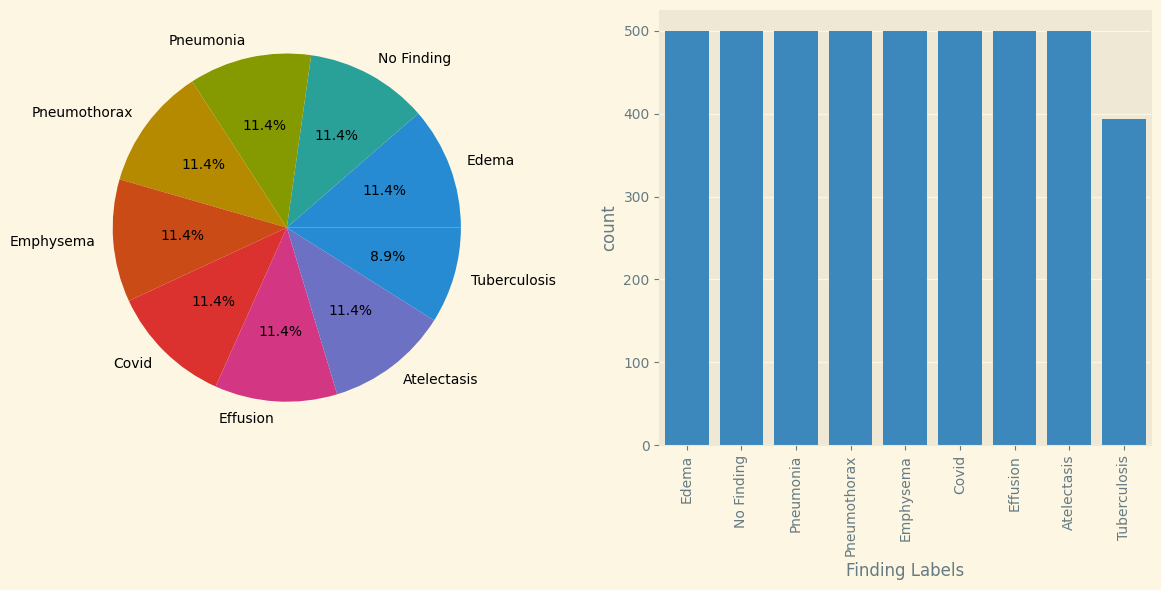

In [9]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Train & Test Split**

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [11]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
TARGET = df_train.columns[-9:].tolist()

In [12]:
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Pneumothorax',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [13]:
import albumentations as albu
print(albu.__version__)

1.4.14


In [21]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data,batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


    def __len__(self):

        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y

    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):

        X = np.zeros((len(indexes),256,256,3), dtype='float32')
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']

            img = Image.open(path).convert('L')  # Load image and convert to grayscale
            img = img.resize((256, 256), Image.Resampling.LANCZOS)  # Resize image
            img = np.array(img)  # Convert PIL image to numpy array
            thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)[1]
            thresh = cv2.erode(thresh, None, iterations=1)
            thresh = cv2.dilate(thresh, None, iterations=1)

            cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

            largest_contour = cnts[0]


            img = self.clahe.apply(img)  # Apply CLAHE for contrast enhancement
            img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (H, W, 1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB

            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            cv2.drawContours(img, [largest_contour], -1, (255,0,0), thickness=3)

            X[j,:,:,:3] = img


            y[j,] = row[TARGET]

        return X,y

    def __augment1(self, img_batch):

        composition = albu.Compose([
                 albu.HorizontalFlip(p=0.5),
        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch


    def __augment2(self, img_batch,cutmix_prob=0.5, num_patches=2):
        batch_size, height, width, channels = img_batch.shape

        for i in range(batch_size):
            if np.random.rand() <= cutmix_prob:
                for _ in range(num_patches):  # 여러 개의 패치를 적용하기 위해 반복문 추가
                    idx = np.random.randint(batch_size)
                    lam = np.random.beta(0.5, 0.5)

                    cut_width = min(int(width * lam), width//5)
                    cut_height = min(int(height * lam), height//5)
                    cut_x = np.random.randint(0, width - cut_width + 1)
                    cut_y = np.random.randint(0, height - cut_height + 1)

                    img_batch[i, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :] = img_batch[idx, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :]

        return img_batch

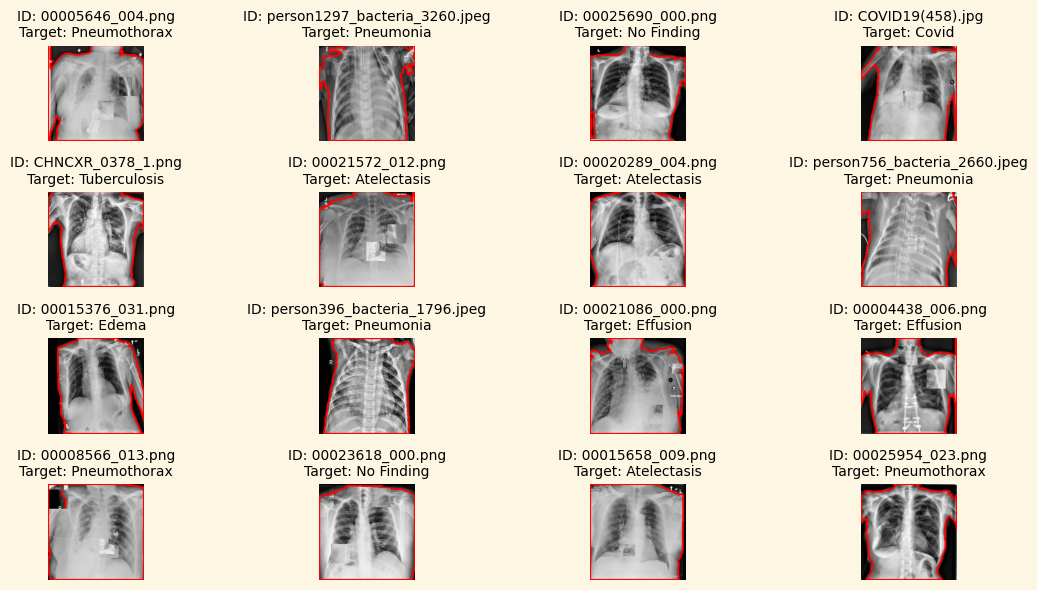

In [22]:
ROWS = 4; COLS = 4; BATCHES = 1


gen = DataGenerator(df_train, batch_size=16, shuffle=False, augment1=True, augment2=True, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break